# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [1]:
import networkx as nx
import numpy as np

from scripts.dataset import concatenate_graph_dataset
from scripts.dataset import generate_graph_dataset
from scripts.dataset import load_concatenated_graph_dataset
from scripts.dataset import PageRankDataset
from scripts.functions import generate_erdos_graph
from scripts.functions import generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.graph_networks import PageRankModelingWithGNN
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

Using backend: pytorch


## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [2]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.2 0.1 0.  0.1 0.2 0.  0.  0.4 0.  0. ]
 [0.  0.3 0.  0.  0.2 0.  0.1 0.1 0.2 0. ]
 [0.  0.3 0.  0.6 0.2 0.  0.  0.  0.2 0.6]
 [0.1 0.  0.  0.3 0.1 0.  0.  0.3 0.  0. ]
 [0.3 0.  0.2 0.  0.1 0.1 0.4 0.  0.  0. ]
 [0.2 0.  0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.2 0.  0.  0.  0.  0.3 0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.2 0.2 0.1 0.3 0. ]
 [0.3 0.  0.  0.  0.1 0.2 0.  0.  0.1 0. ]
 [0.  0.1 0.4 0.  0.1 0.4 0.  0.  0.2 0.4]]


In [3]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 13 with epsilon=1e-05.


array([[0.07971771],
       [0.06628578],
       [0.19802813],
       [0.06819137],
       [0.09293397],
       [0.09609434],
       [0.0419967 ],
       [0.07993989],
       [0.06568496],
       [0.21112716]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [4]:
g = generate_erdos_graph(10, 0.3)

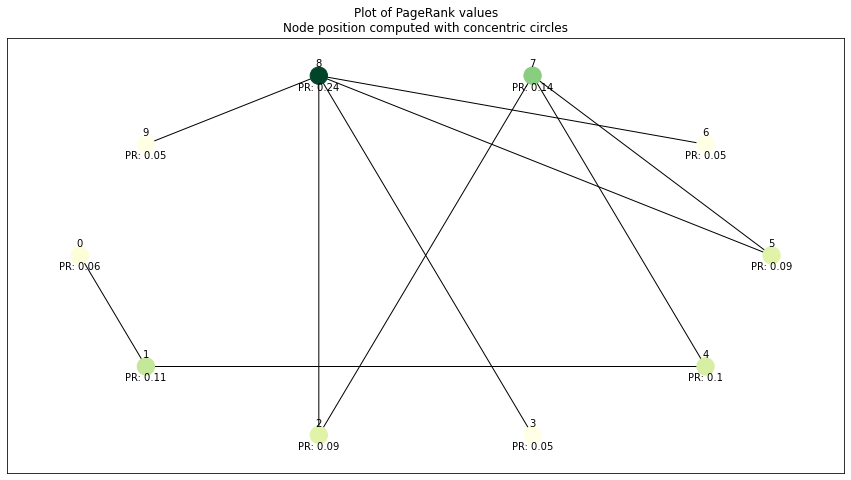

In [5]:
plot_graph(g, layout="shell")

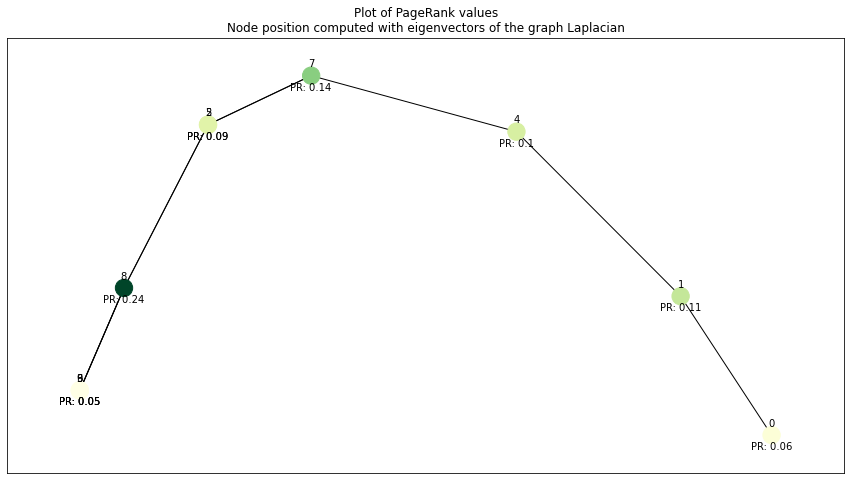

In [6]:
plot_graph(g, layout="spectral")

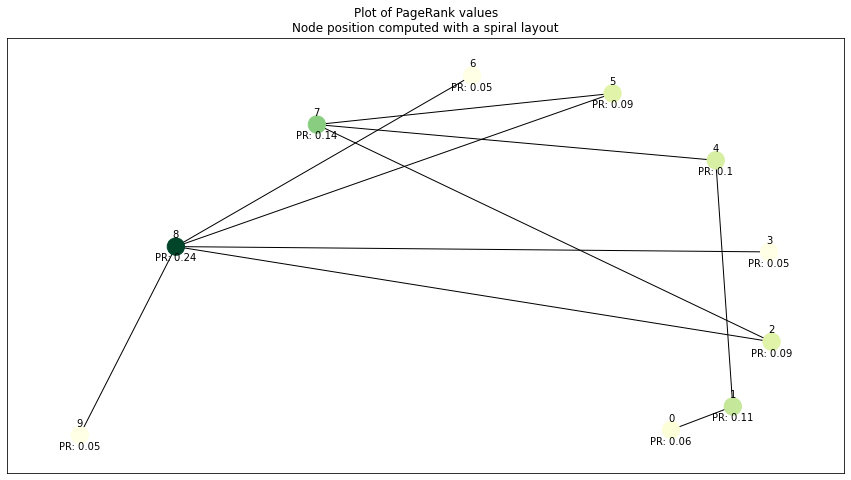

In [7]:
plot_graph(g, layout="spiral")

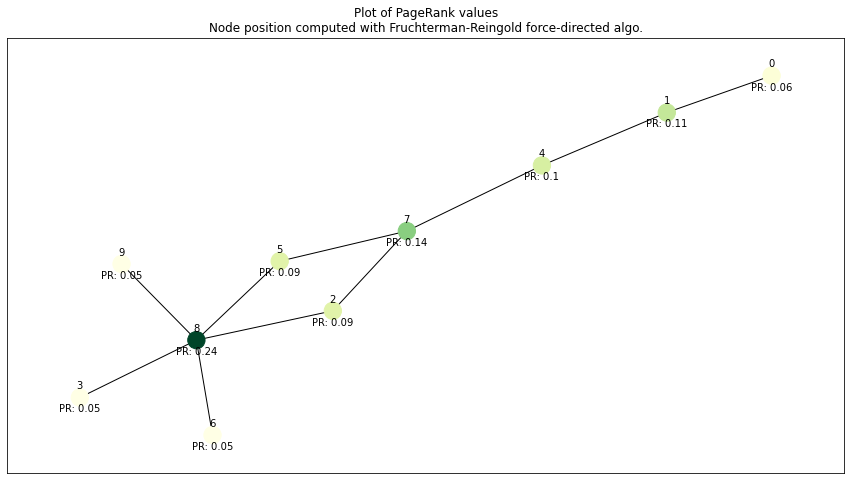

In [8]:
plot_graph(g, layout="spring")

### 2.2. Generating an Example Scale-Free Graph

In [9]:
g = generate_scale_free_graph(10)

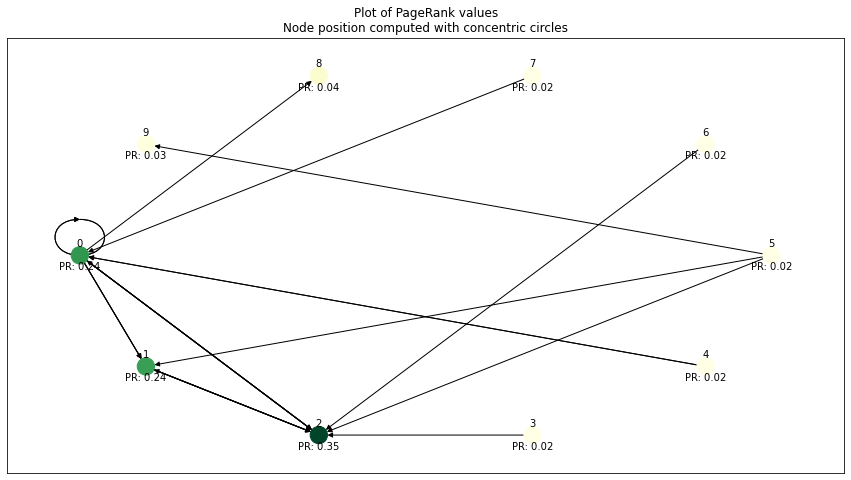

In [10]:
plot_graph(g, layout="shell")

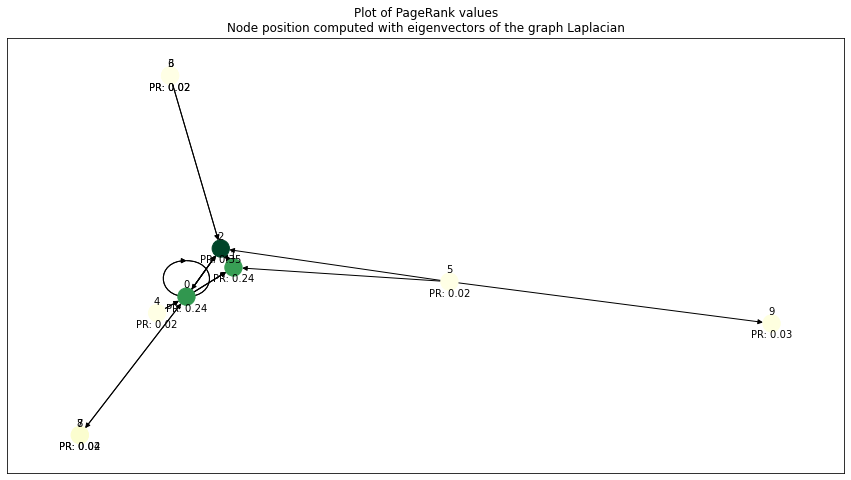

In [11]:
plot_graph(g, layout="spectral")

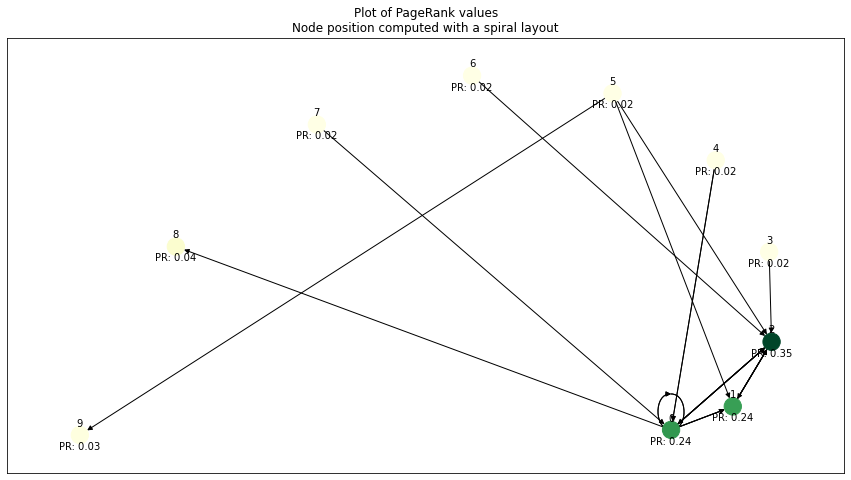

In [12]:
plot_graph(g, layout="spiral")

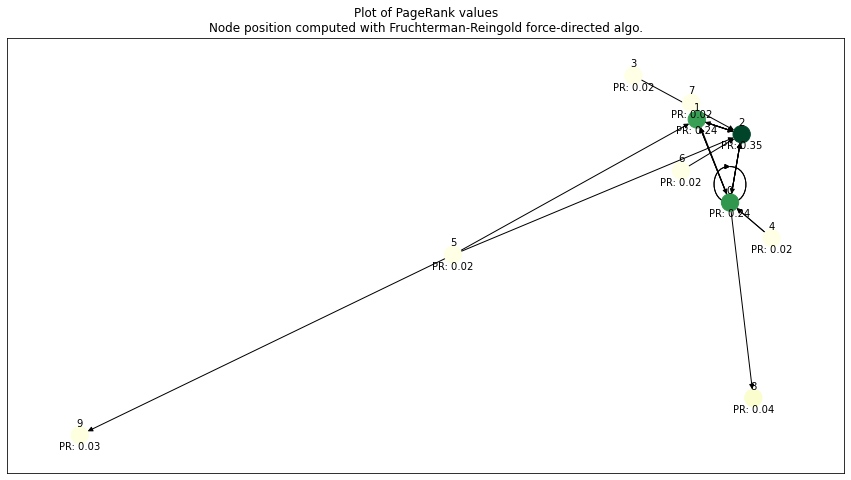

In [13]:
plot_graph(g, layout="spring")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [14]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(100, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


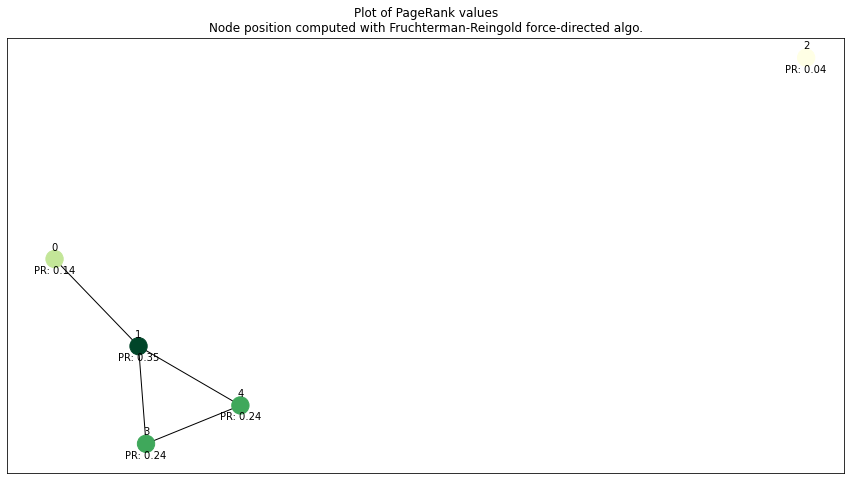

{0: 0.13629777039596325,
 1: 0.35347942441816593,
 2: 0.03614457831325302,
 3: 0.23703911343630887,
 4: 0.23703911343630887}

In [15]:
plot_graph(eX[50])
ey[50]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [16]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(100, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


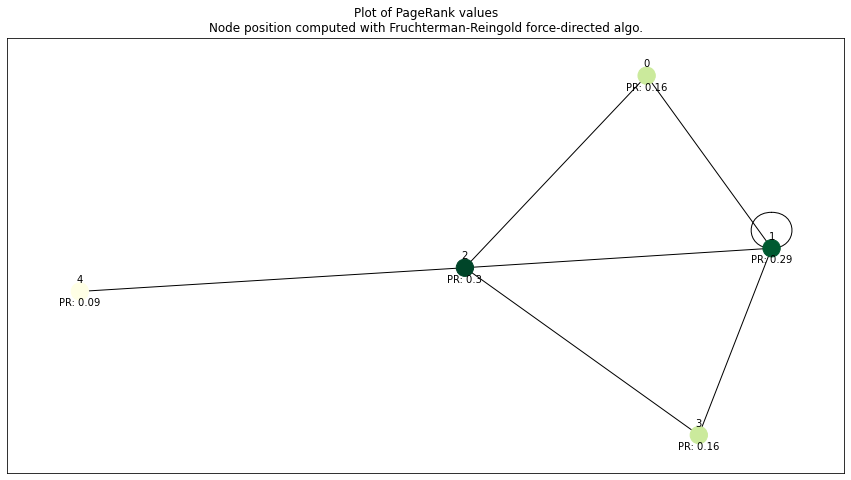

{0: 0.15605258003281877,
 1: 0.288697832136115,
 2: 0.3044926614373587,
 3: 0.15605258003281877,
 4: 0.09470434636088892}

In [17]:
plot_graph(sfX[50])
sfy[50]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate two graphs with either Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.6} |
| N |  Range of nodes to generate graphs |  {60} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 1 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 2 |


In [18]:
# Declares the parameters

P            = [0.3]
N            = [15]
n_erdos      = 1
n_scale_free = 1

<u>Building the dataset</u>

We build 8 singular graphs each with a PageRank value per node, resulting in c. 70 nodes and 120 edges.

In [19]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=15, p=0.3

Generating Scale-Free graphs with parameter:
	Completed -- n=15


print(len(X), len(y))

print("Adjacency matrix of 0th graph:",
      nx.adjacency_matrix(X[0]).todense(),
      "\nPageRank values per node of 0th graph:",
      y[0],
      sep="\n")

<u>Merging all graphs into a single entity and saving it</u>

We implement a function to concatenate all the generated graphs into a single large graph that can be used as input to a Graph Neural Network.

**Of note**, the cell is inactive on the assumption that it was already run and the result can be loaded using the load function located in the next cell.

In [20]:
pathX = "graph_files/graph_record02112022.graphml"
pathy = "graph_files/graph_record02112022_PageRanks.txt"

In [21]:
graphs, pageranks = concatenate_graph_dataset(X, y, pathX, pathy)

In [22]:
graphs, pageranks = load_concatenated_graph_dataset(pathX, pathy)

In [23]:
print(len(graphs.nodes), len(graphs.edges))

30 58


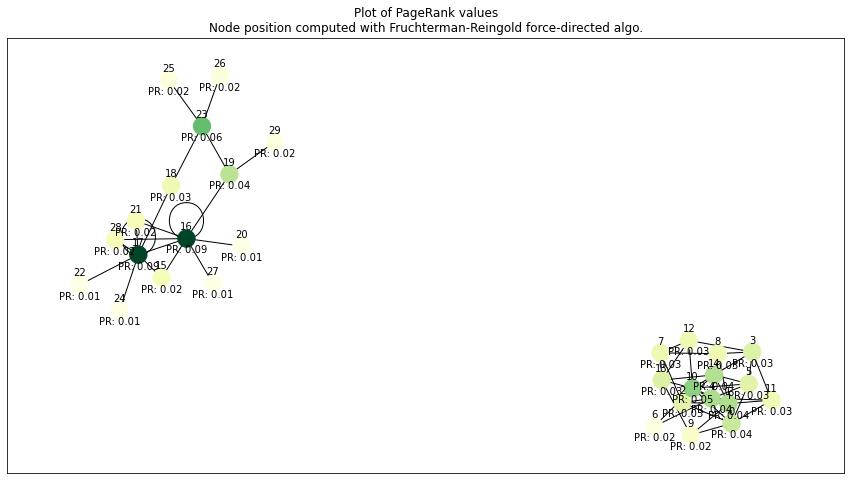

In [24]:
plot_graph(graphs)

<u>Building the DGL PageRank dataset</u>

In [25]:
dataset = PageRankDataset(graphs, pageranks, use_noise=True)
graph_noise_as_features = dataset[0]

dataset = PageRankDataset(graphs, pageranks, use_noise=False)
graph_torcheye_as_features = dataset[0]

### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN models (graph with noise as feature):</u>

In [26]:
# Declares some variables
hidden_features = 8
epochs = 500

In [27]:
GCN_model_h10_adam_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                  hidden_features, 
                                                  epochs, 
                                                  "GCN",
                                                  print_description = True)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv




In [28]:
GCN_model_h10_adamw_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                    hidden_features, 
                                                    epochs, 
                                                    "GCN",
                                                    optimizer = "AdamW")

In [29]:
GCN_model_h10_adamax_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                    hidden_features, 
                                                    epochs, 
                                                    "GCN",
                                                    optimizer = "Adamax")

In [30]:
GCN_model_h10_adadelta_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                       hidden_features, 
                                                       epochs, 
                                                       "GCN",
                                                       optimizer = "Adadelta")

In [31]:
GCN_model_h10_SGD_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                  hidden_features, 
                                                  epochs, 
                                                  "GCN",
                                                  optimizer = "SGD")

In [32]:
SAGE_model_h10_adam_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                    hidden_features, 
                                                    epochs, 
                                                    "SAGE",
                                                    print_description = True)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [33]:
SAGE_model_h10_adamw_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                     hidden_features, 
                                                     epochs, 
                                                     "SAGE",
                                                     optimizer = "AdamW")

In [34]:
SAGE_model_h10_adamax_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                      hidden_features, 
                                                      epochs, 
                                                      "SAGE",
                                                      optimizer = "Adamax")

In [35]:
SAGE_model_h10_adadelta_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                        hidden_features, 
                                                        epochs, 
                                                        "SAGE",
                                                        optimizer = "Adadelta")

In [36]:
SAGE_model_h10_SGD_noise = PageRankModelingWithGNN(graph_noise_as_features, 
                                                   hidden_features, 
                                                   epochs, 
                                                   "SAGE",
                                                   optimizer = "SGD")

<u>Convolutional GNN models (graph with torcheye as feature):</u>

In [37]:
# Declares some variables
hidden_features = 8
epochs = 500

In [38]:
GCN_model_h10_adam_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                 hidden_features, 
                                                 epochs, 
                                                 "GCN",
                                                 print_description = True)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv




In [39]:
GCN_model_h10_adamw_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                  hidden_features, 
                                                  epochs, 
                                                  "GCN",
                                                  optimizer = "AdamW")

In [40]:
GCN_model_h10_adamax_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                   hidden_features, 
                                                   epochs, 
                                                   "GCN",
                                                   optimizer = "Adamax")

In [41]:
GCN_model_h10_adadelta_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                     hidden_features, 
                                                     epochs, 
                                                     "GCN",
                                                     optimizer = "Adadelta")

In [42]:
GCN_model_h10_SGD_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                hidden_features, 
                                                epochs, 
                                                "GCN",
                                                optimizer = "SGD")

In [43]:
SAGE_model_h10_adam_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                  hidden_features, 
                                                  epochs, 
                                                  "SAGE",
                                                  print_description = True)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [44]:
SAGE_model_h10_adamw_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                   hidden_features, 
                                                   epochs, 
                                                   "SAGE",
                                                   optimizer = "AdamW")

In [45]:
SAGE_model_h10_adamax_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                    hidden_features, 
                                                    epochs, 
                                                    "SAGE",
                                                    optimizer = "Adamax")

In [46]:
SAGE_model_h10_adadelta_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                      hidden_features, 
                                                      epochs, 
                                                      "SAGE",
                                                      optimizer = "Adadelta")

In [47]:
SAGE_model_h10_SGD_eye = PageRankModelingWithGNN(graph_noise_as_features, 
                                                 hidden_features, 
                                                 epochs, 
                                                 "SAGE",
                                                 optimizer = "SGD")

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN models (graph with noise as feature):</u>

Epoch 0,	loss: 0.01199;		val loss 0.001052
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 17             ####
Test loss: 0.000398


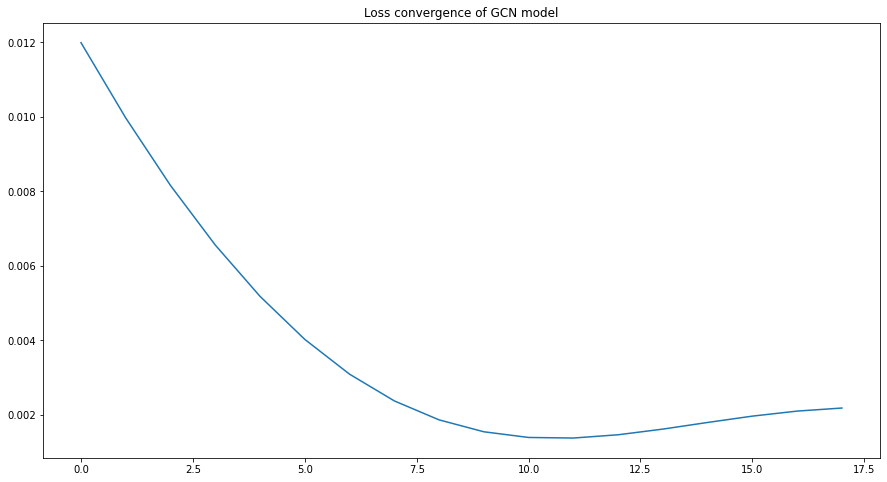



Plot with true labels
---------------------


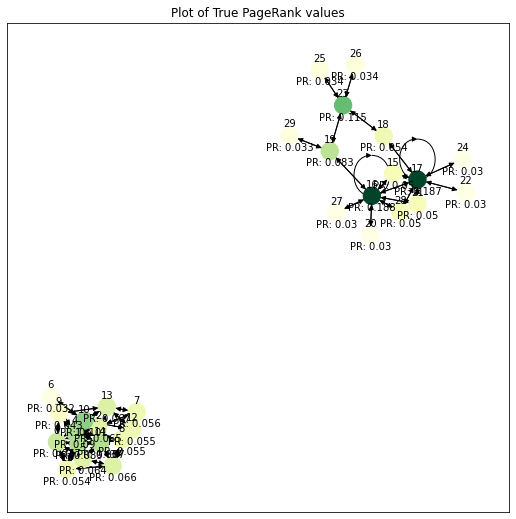

Plot with predicted labels
--------------------------


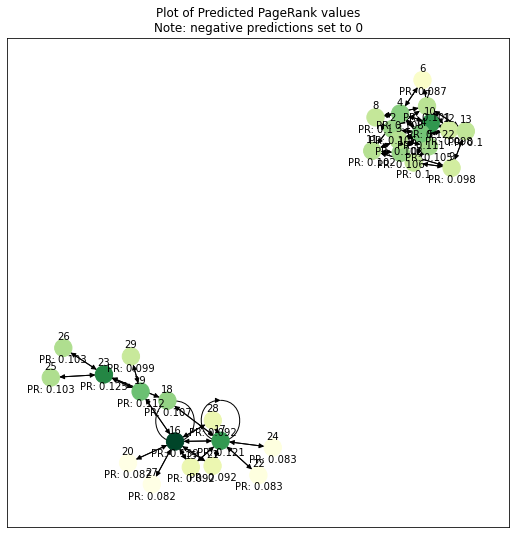

In [48]:
GCN_model_h10_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.001593;		val loss 5.2e-05
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 19             ####
Test loss: 1.9e-05


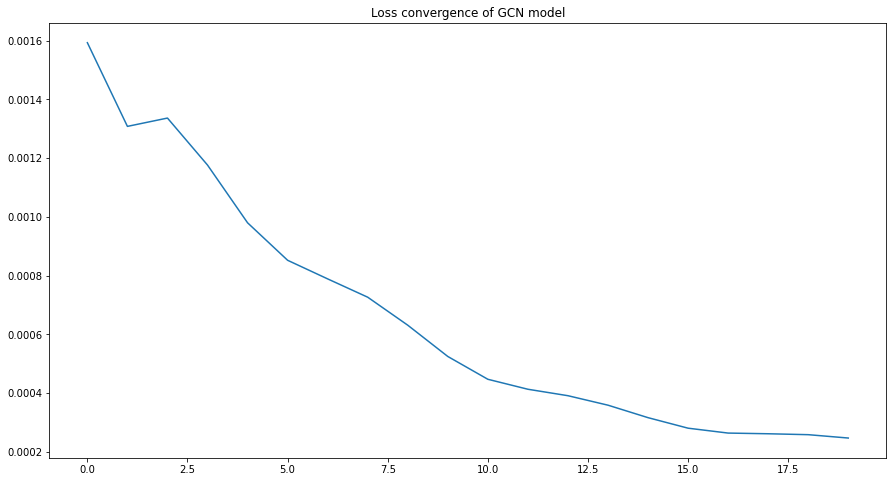



Plot with true labels
---------------------


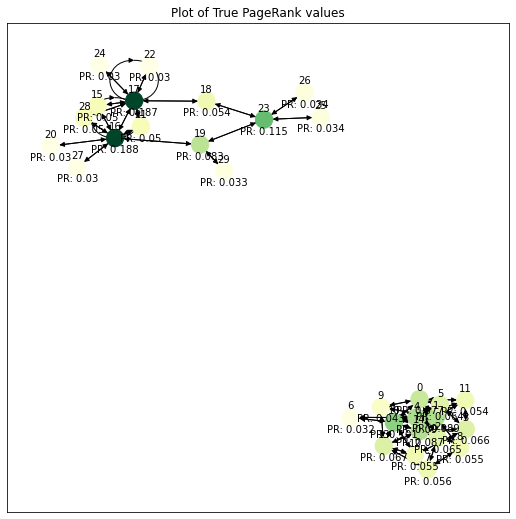

Plot with predicted labels
--------------------------


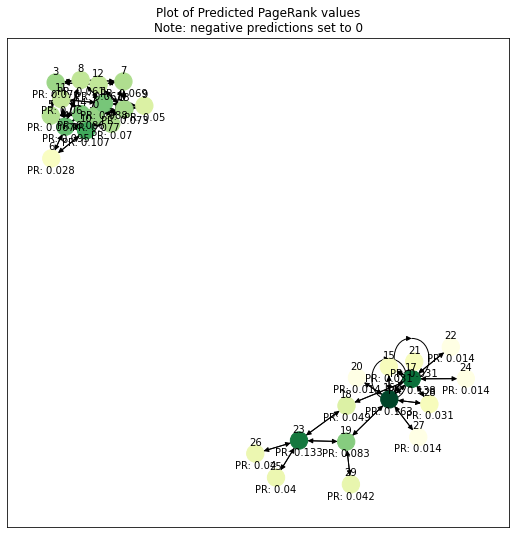

In [49]:
GCN_model_h10_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.083351;		val loss 0.008001
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 27             ####
Test loss: 0.00017


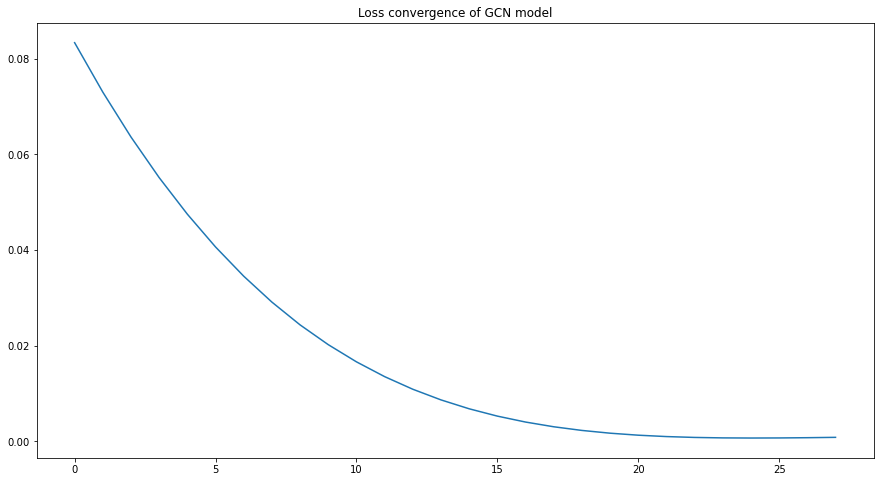



Plot with true labels
---------------------


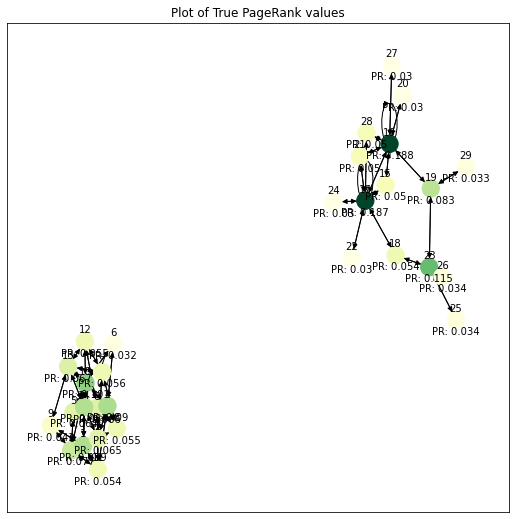

Plot with predicted labels
--------------------------


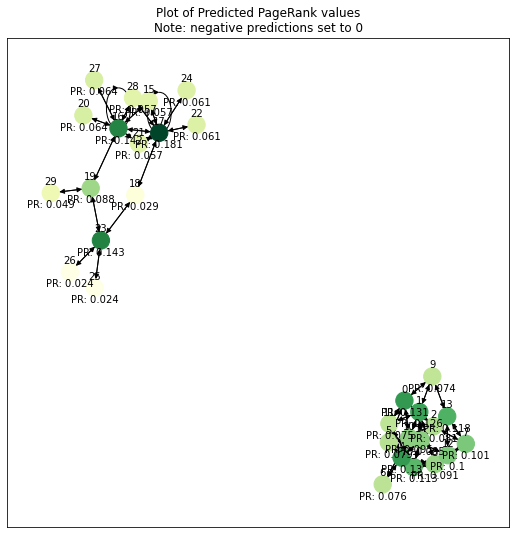

In [50]:
GCN_model_h10_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.019134;		val loss 0.002159
Epoch 50,	loss: 0.018676;		val loss 0.00209
Epoch 100,	loss: 0.018155;		val loss 0.002013
Epoch 150,	loss: 0.017588;		val loss 0.001929
Epoch 200,	loss: 0.016988;		val loss 0.001841
Epoch 250,	loss: 0.016362;		val loss 0.00175
Epoch 300,	loss: 0.015719;		val loss 0.001656
Epoch 350,	loss: 0.015064;		val loss 0.001562
Epoch 400,	loss: 0.014412;		val loss 0.001467
Epoch 450,	loss: 0.013757;		val loss 0.001373
Test loss: 0.00182


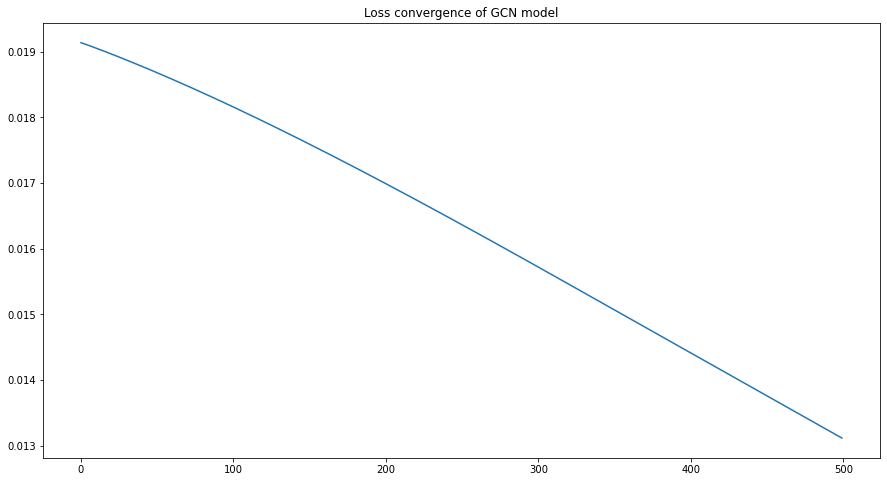



Plot with true labels
---------------------


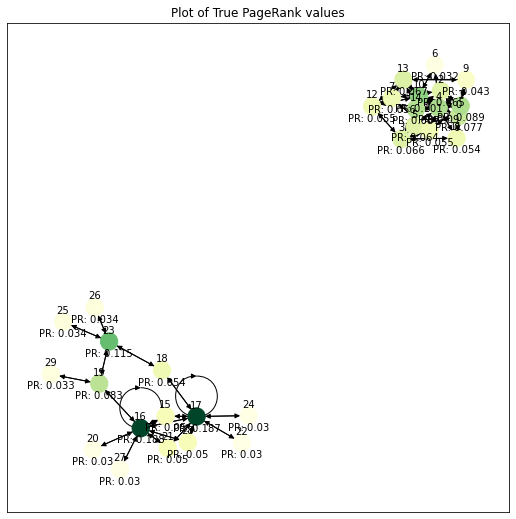

Plot with predicted labels
--------------------------


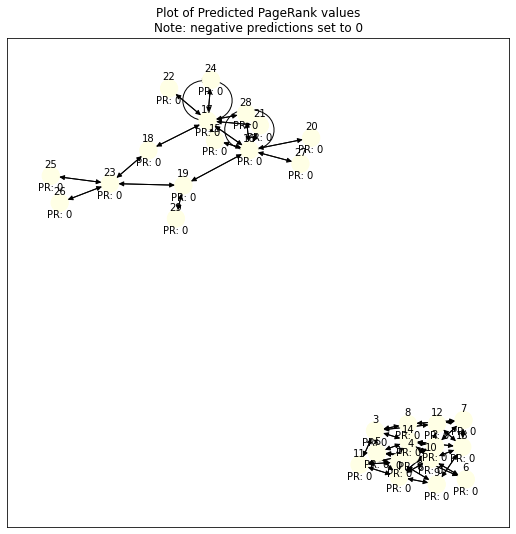

In [51]:
GCN_model_h10_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.004229;		val loss 0.000414
Epoch 50,	loss: 0.001574;		val loss 7.1e-05
Epoch 100,	loss: 0.001097;		val loss 4.1e-05
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 116             ####
Test loss: 3.6e-05


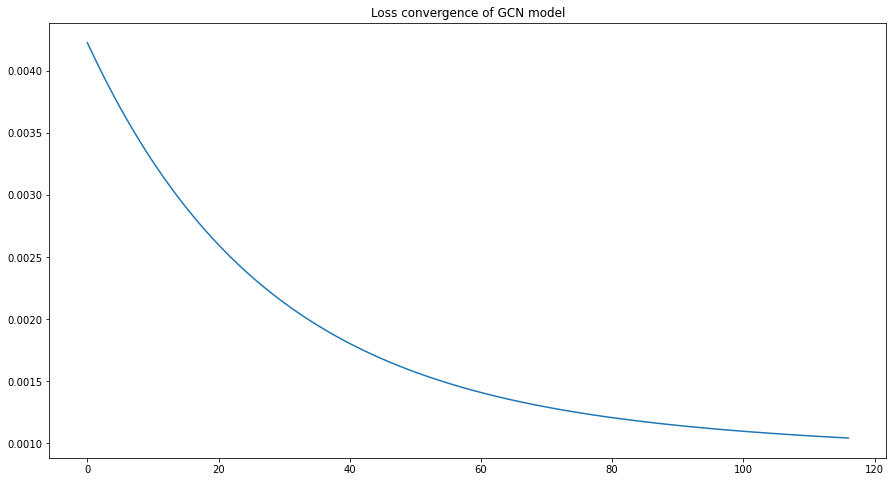



Plot with true labels
---------------------


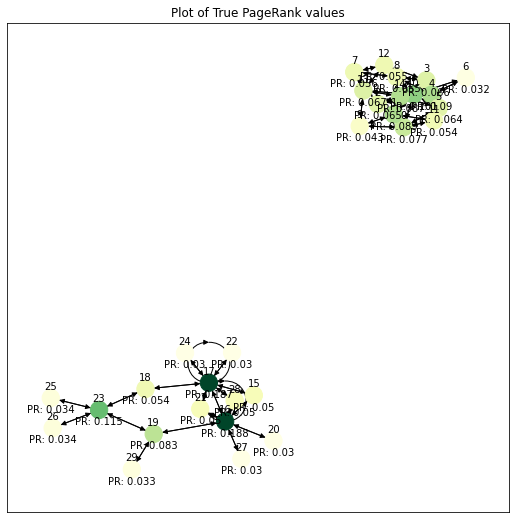

Plot with predicted labels
--------------------------


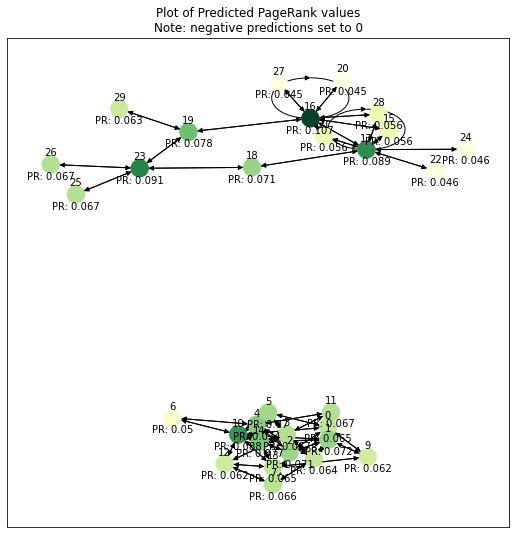

In [52]:
GCN_model_h10_SGD_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.450777;		val loss 0.109614
Epoch 50,	loss: 0.031541;		val loss 0.011464
Epoch 100,	loss: 0.0144;		val loss 0.006152
Epoch 150,	loss: 0.008941;		val loss 0.004308
Epoch 200,	loss: 0.006502;		val loss 0.00323
Epoch 250,	loss: 0.005058;		val loss 0.002482
Epoch 300,	loss: 0.004362;		val loss 0.002191
Epoch 350,	loss: 0.00387;		val loss 0.001992
Epoch 400,	loss: 0.00352;		val loss 0.001838
Epoch 450,	loss: 0.00327;		val loss 0.001719
Test loss: 0.001515


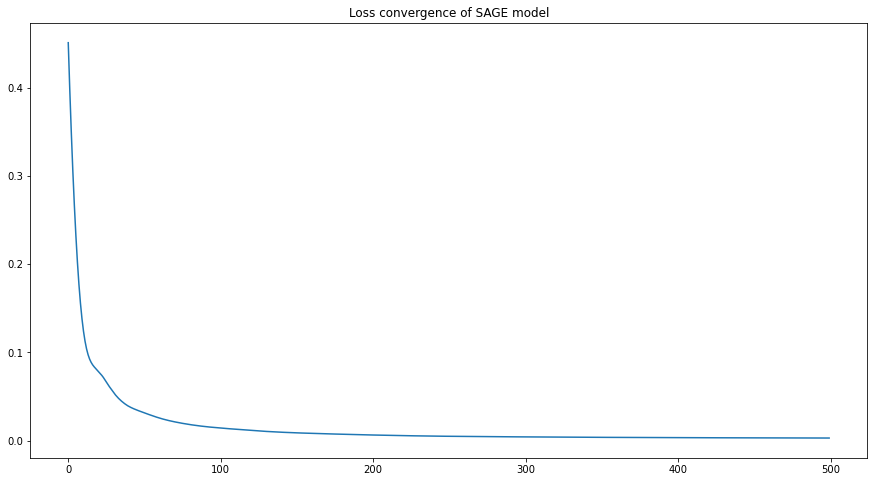



Plot with true labels
---------------------


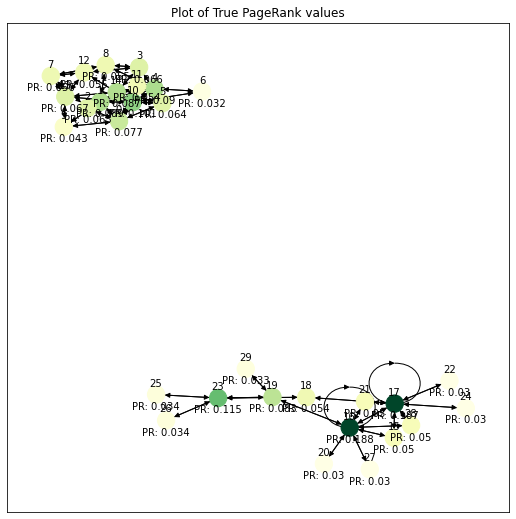

Plot with predicted labels
--------------------------


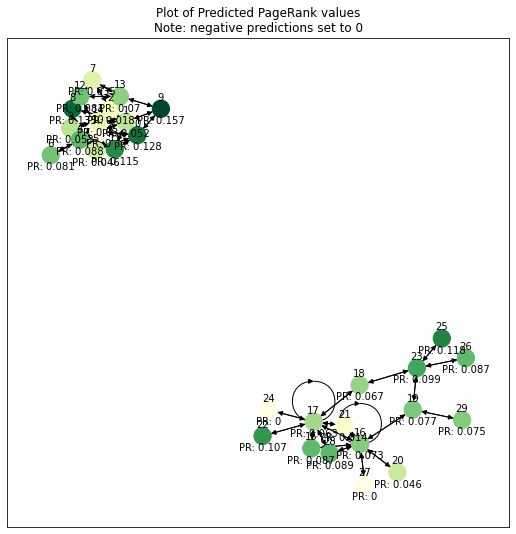

In [53]:
SAGE_model_h10_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 1.263509;		val loss 0.26685
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 37             ####
Test loss: 0.001476


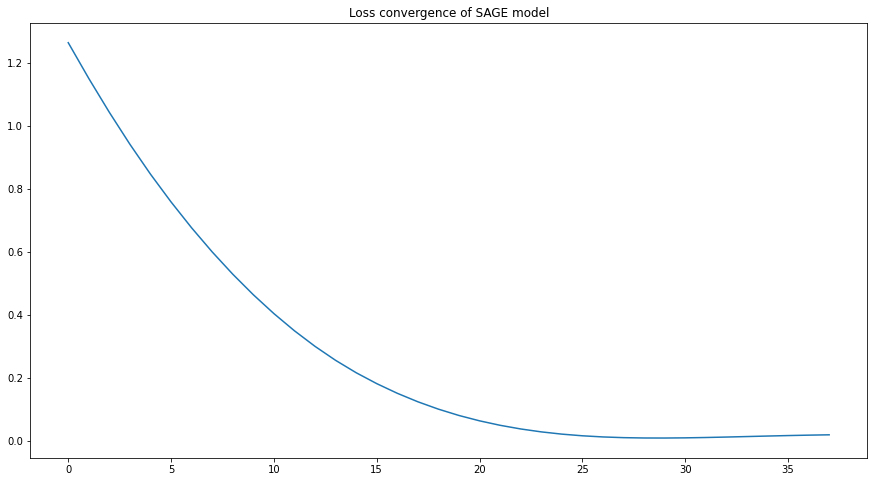



Plot with true labels
---------------------


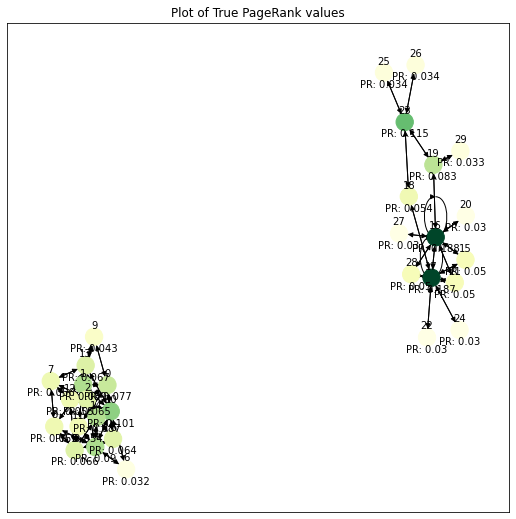

Plot with predicted labels
--------------------------


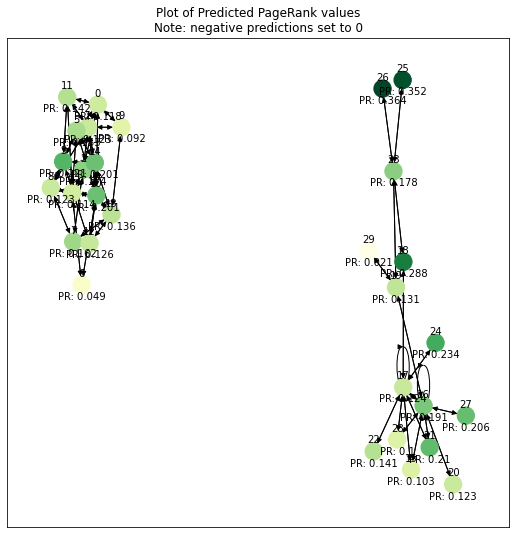

In [54]:
SAGE_model_h10_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.089547;		val loss 0.02655
Epoch 50,	loss: 0.00595;		val loss 0.004296
Epoch 100,	loss: 0.003359;		val loss 0.002259
Epoch 150,	loss: 0.002951;		val loss 0.001753
Epoch 200,	loss: 0.002713;		val loss 0.001503
Epoch 250,	loss: 0.002511;		val loss 0.001465
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 253             ####
Test loss: 0.000582


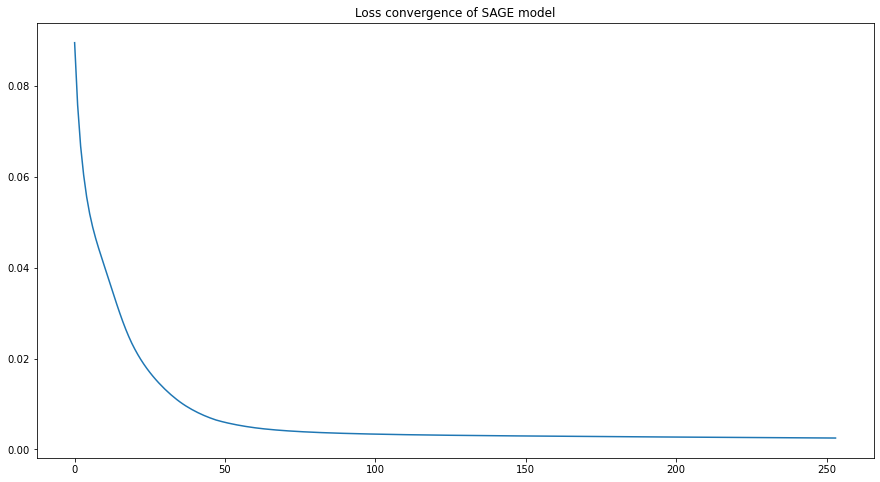



Plot with true labels
---------------------


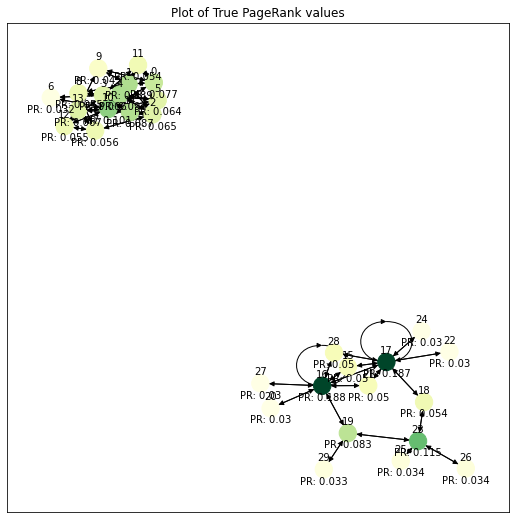

Plot with predicted labels
--------------------------


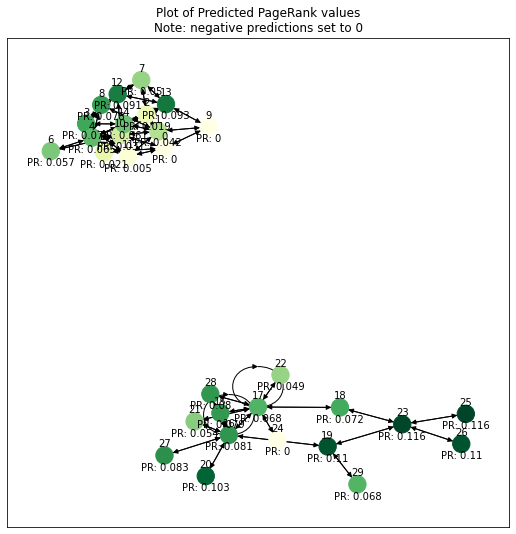

In [55]:
SAGE_model_h10_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.11476;		val loss 0.092881
Epoch 50,	loss: 0.111575;		val loss 0.089445
Epoch 100,	loss: 0.108368;		val loss 0.085867
Epoch 150,	loss: 0.105253;		val loss 0.082285
Epoch 200,	loss: 0.102261;		val loss 0.078788
Epoch 250,	loss: 0.099378;		val loss 0.075473
Epoch 300,	loss: 0.096562;		val loss 0.072368
Epoch 350,	loss: 0.093129;		val loss 0.069045
Epoch 400,	loss: 0.089234;		val loss 0.065524
Epoch 450,	loss: 0.085162;		val loss 0.061913
Test loss: 0.038146


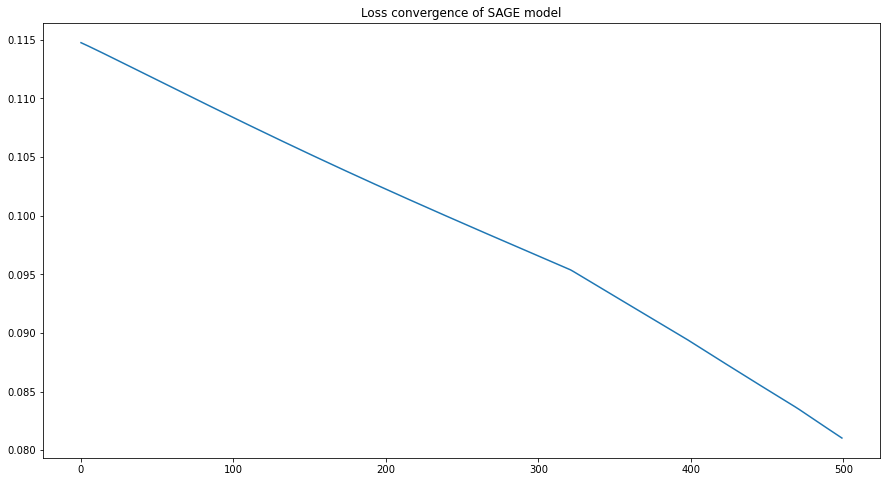



Plot with true labels
---------------------


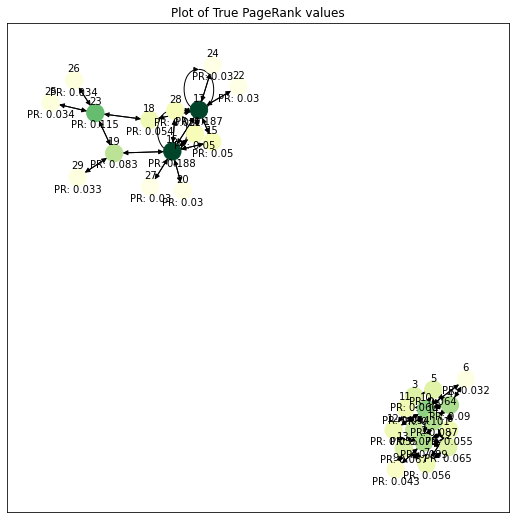

Plot with predicted labels
--------------------------


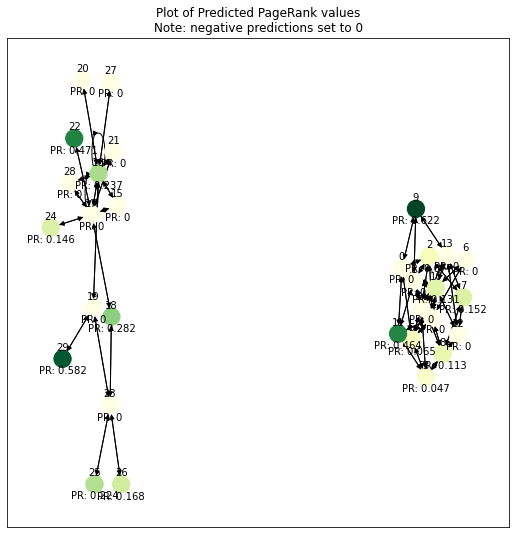

In [56]:
SAGE_model_h10_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.320761;		val loss 0.040515
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 22             ####
Test loss: 0.012196


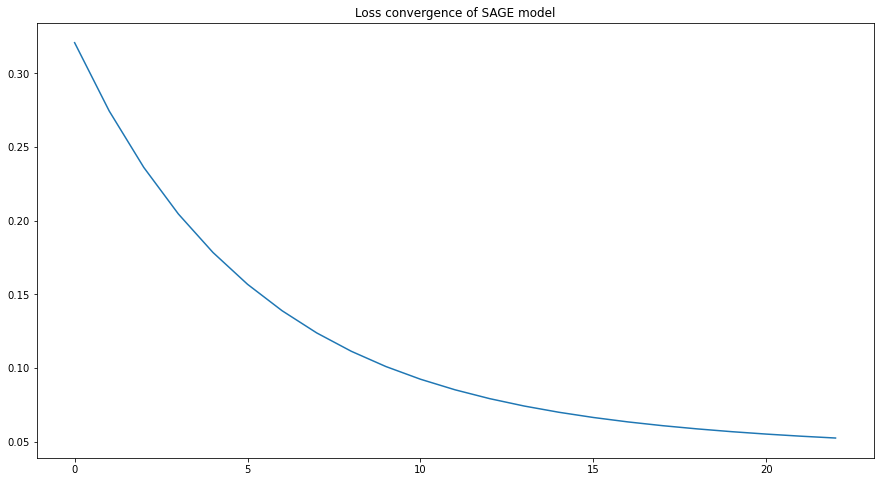



Plot with true labels
---------------------


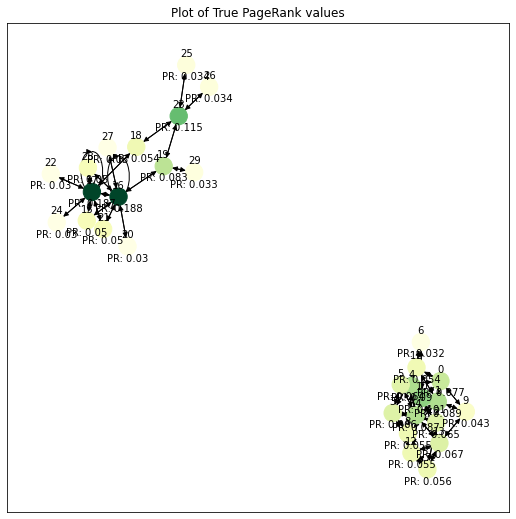

Plot with predicted labels
--------------------------


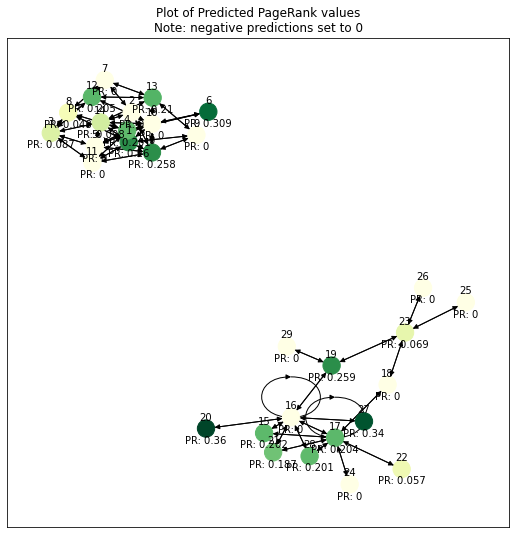

In [57]:
SAGE_model_h10_SGD_noise.run(print_graph_results=True)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

Epoch 0,	loss: 0.006164;		val loss 0.000226
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 28             ####
Test loss: 1.5e-05


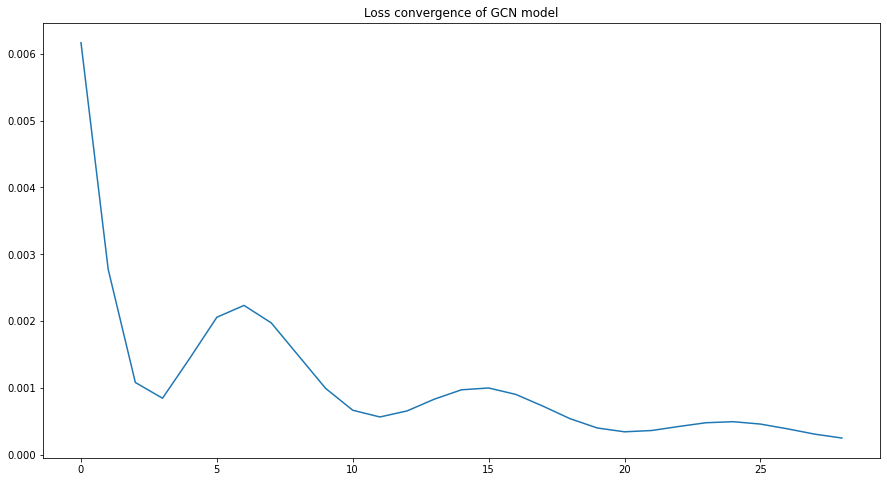



Plot with true labels
---------------------


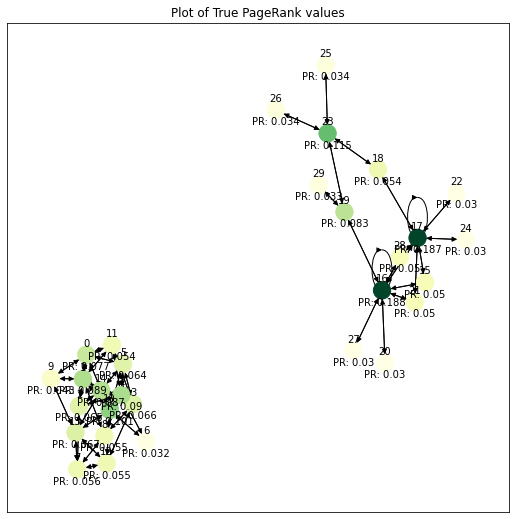

Plot with predicted labels
--------------------------


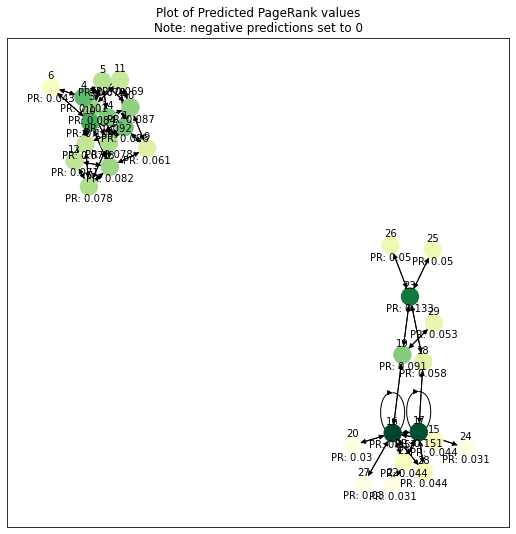

In [58]:
GCN_model_h10_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.029256;		val loss 0.002346
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 20             ####
Test loss: 7.5e-05


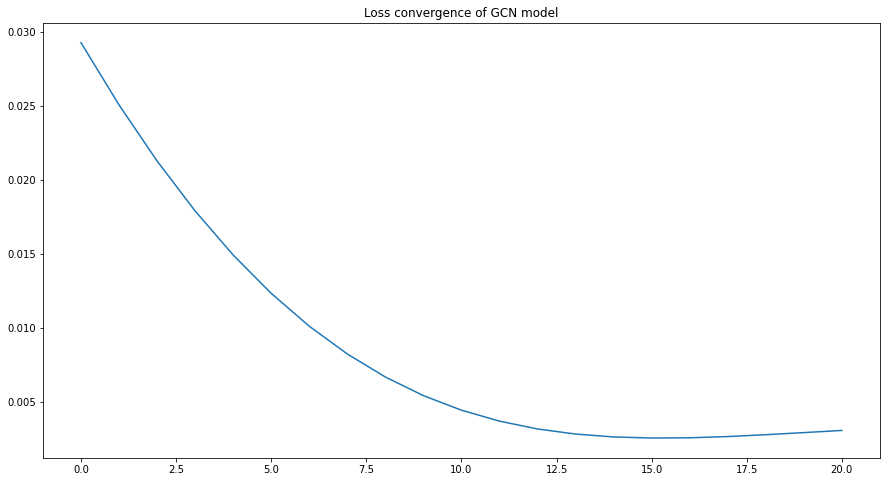



Plot with true labels
---------------------


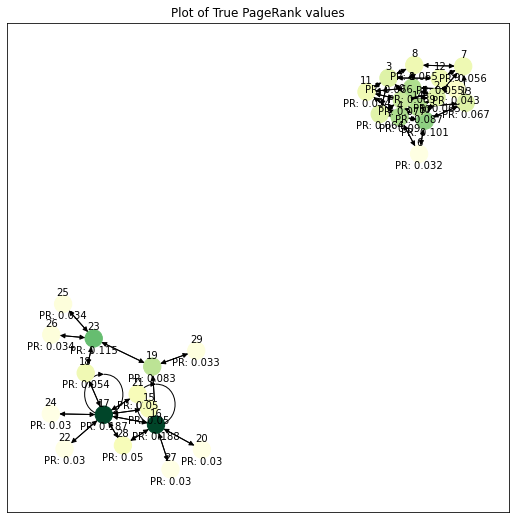

Plot with predicted labels
--------------------------


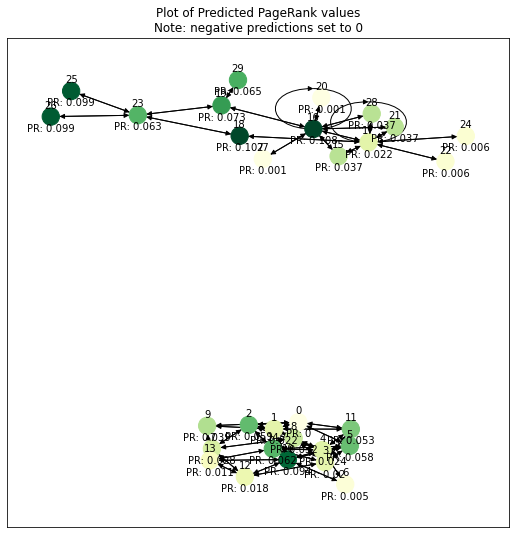

In [59]:
GCN_model_h10_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.002544;		val loss 0.000131
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 13             ####
Test loss: 9.7e-05


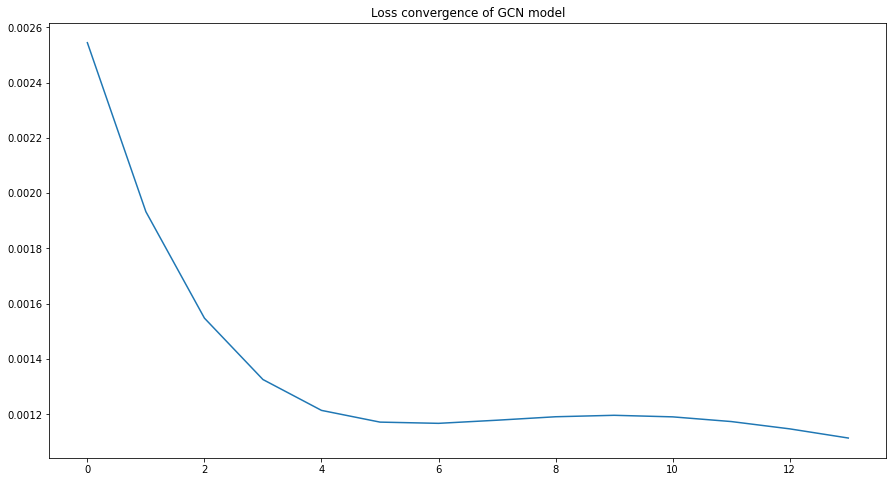



Plot with true labels
---------------------


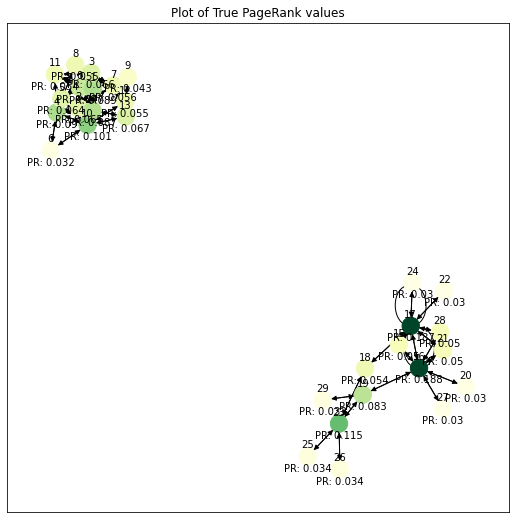

Plot with predicted labels
--------------------------


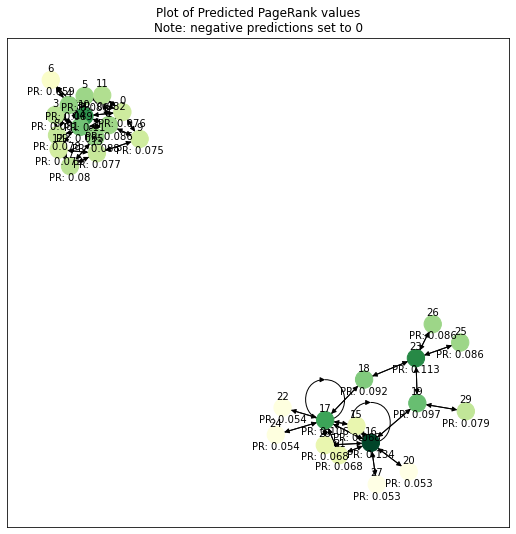

In [60]:
GCN_model_h10_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.018044;		val loss 0.002033
Epoch 50,	loss: 0.016799;		val loss 0.001869
Epoch 100,	loss: 0.015437;		val loss 0.001692
Epoch 150,	loss: 0.014021;		val loss 0.001509
Epoch 200,	loss: 0.012592;		val loss 0.001326
Epoch 250,	loss: 0.011183;		val loss 0.001148
Epoch 300,	loss: 0.00982;		val loss 0.000977
Epoch 350,	loss: 0.008524;		val loss 0.000817
Epoch 400,	loss: 0.007312;		val loss 0.00067
Epoch 450,	loss: 0.006202;		val loss 0.000538
Test loss: 0.000612


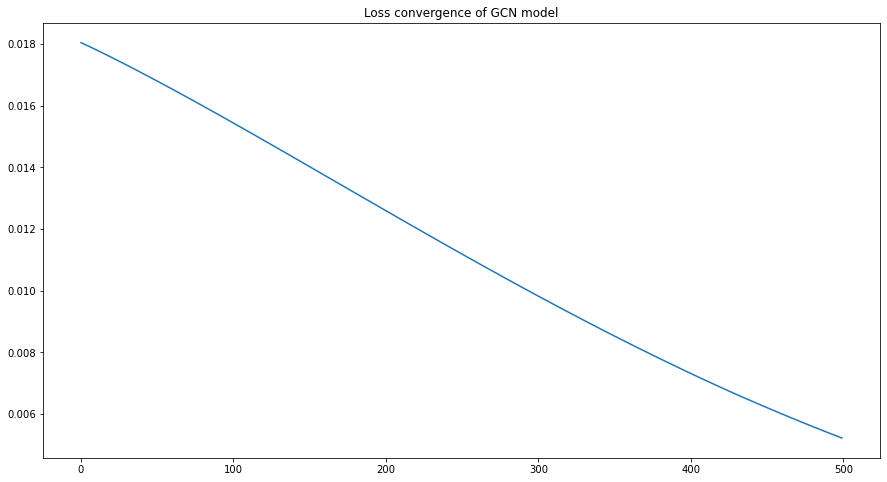



Plot with true labels
---------------------


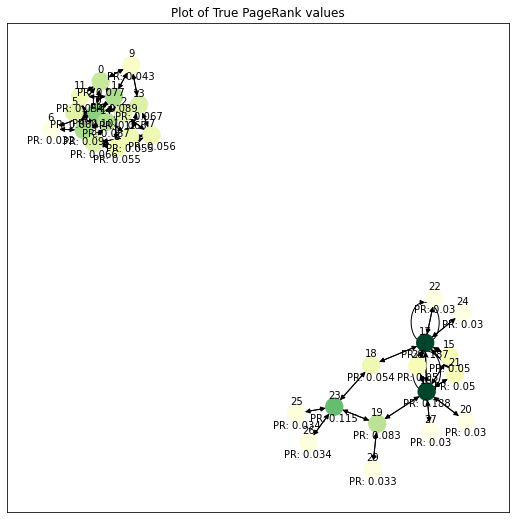

Plot with predicted labels
--------------------------


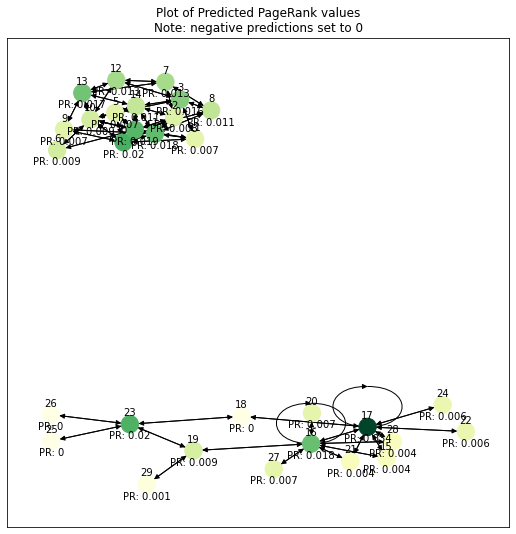

In [61]:
GCN_model_h10_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.39456;		val loss 0.03977
Epoch 50,	loss: 0.022394;		val loss 0.000132
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 66             ####
Test loss: 0.001088


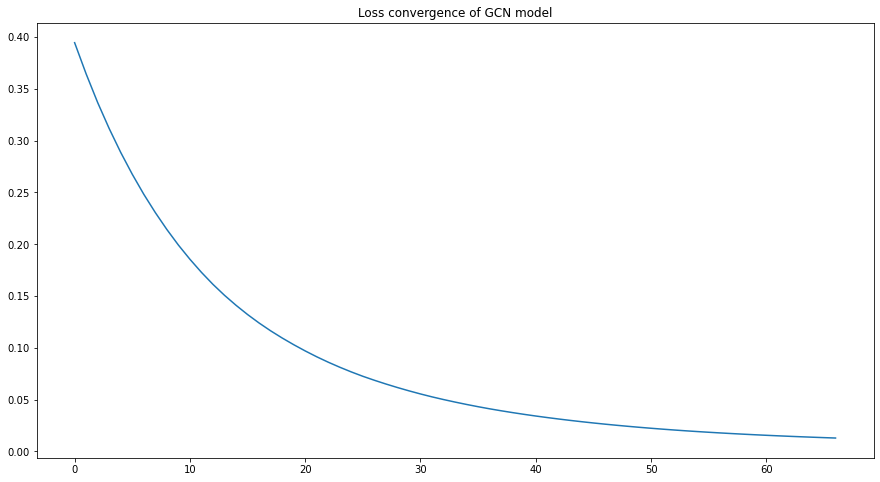



Plot with true labels
---------------------


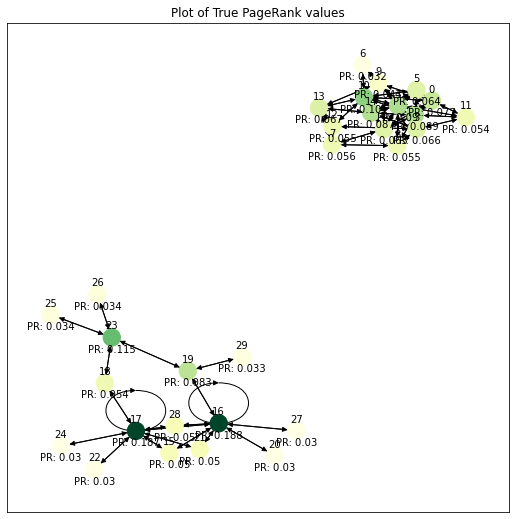

Plot with predicted labels
--------------------------


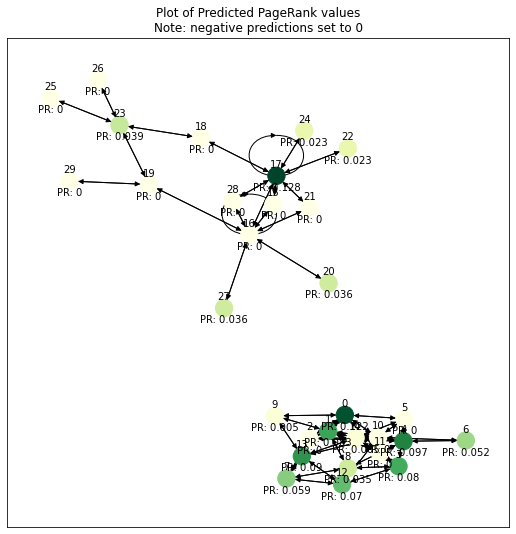

In [62]:
GCN_model_h10_SGD_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.224465;		val loss 0.014322
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 11             ####
Test loss: 0.011699


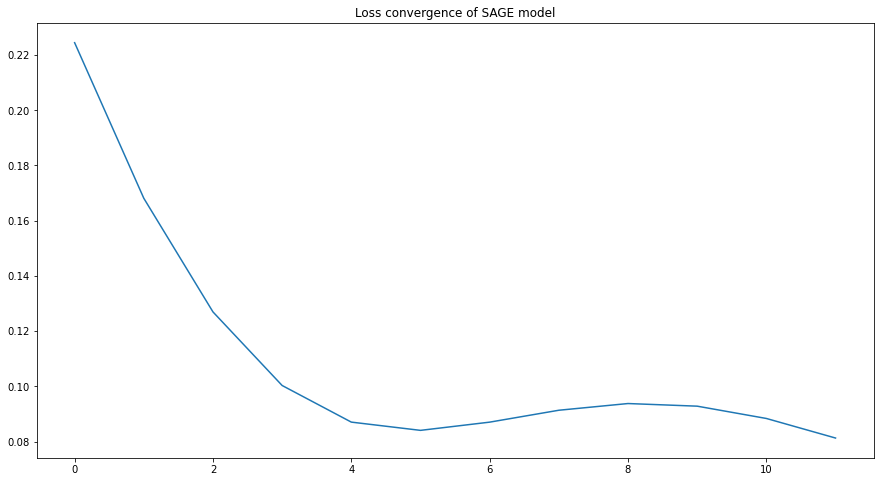



Plot with true labels
---------------------


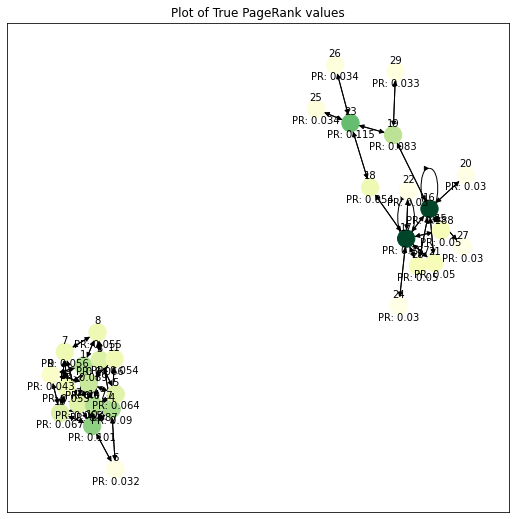

Plot with predicted labels
--------------------------


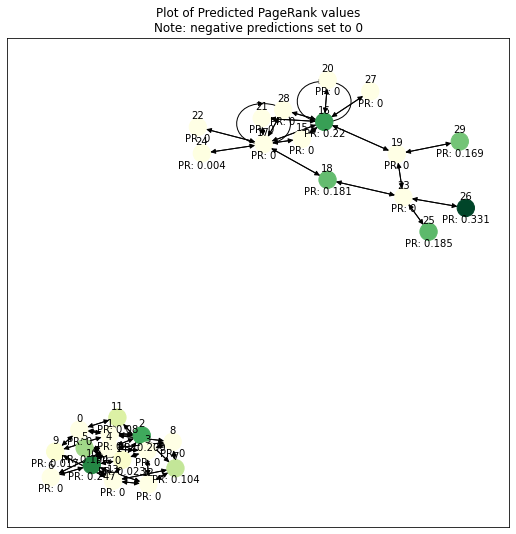

In [63]:
SAGE_model_h10_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.83235;		val loss 0.279874
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 44             ####
Test loss: 0.004544


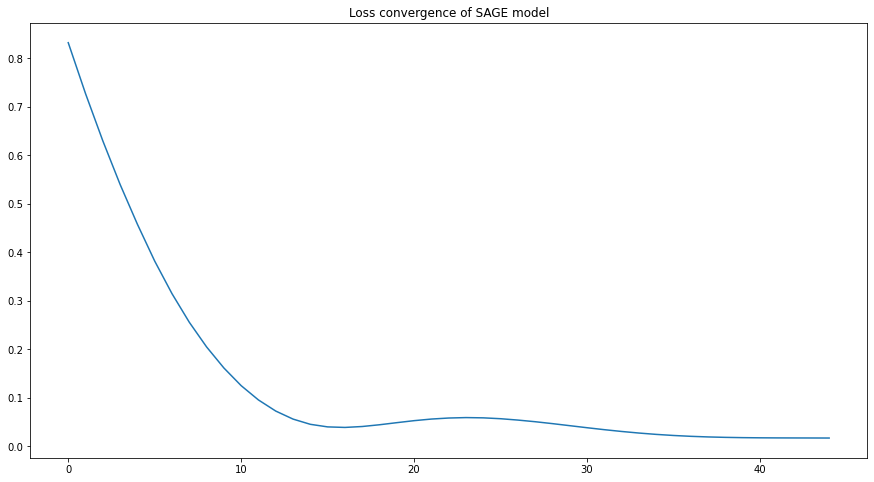



Plot with true labels
---------------------


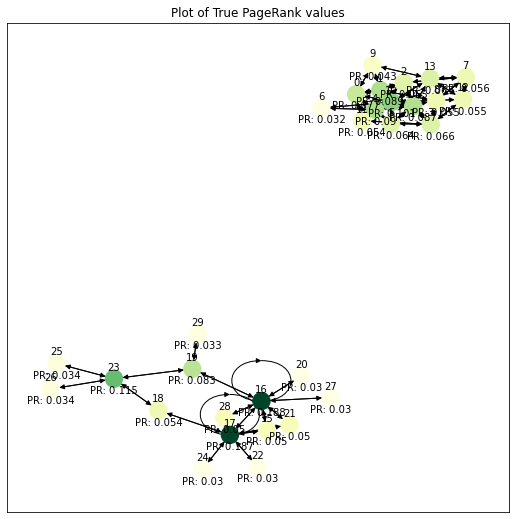

Plot with predicted labels
--------------------------


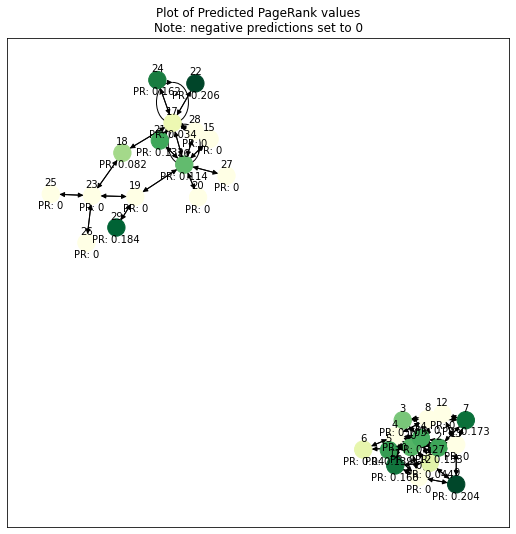

In [64]:
SAGE_model_h10_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.084663;		val loss 0.0489
Epoch 50,	loss: 0.008865;		val loss 0.006489
Epoch 100,	loss: 0.005832;		val loss 0.003759
Epoch 150,	loss: 0.004833;		val loss 0.00277
Epoch 200,	loss: 0.004159;		val loss 0.002067
Epoch 250,	loss: 0.00353;		val loss 0.001541
Epoch 300,	loss: 0.003137;		val loss 0.001222
Epoch 350,	loss: 0.002894;		val loss 0.000976
Epoch 400,	loss: 0.002739;		val loss 0.000807
Epoch 450,	loss: 0.002635;		val loss 0.000691
Test loss: 0.000883


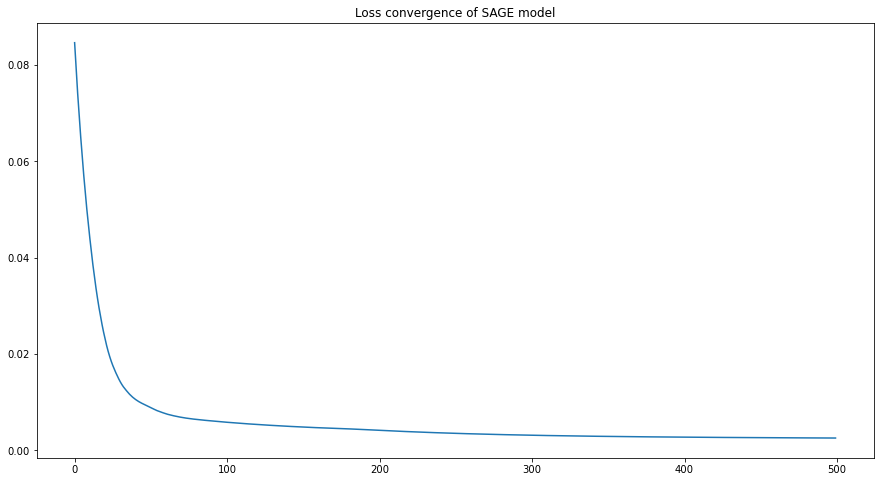



Plot with true labels
---------------------


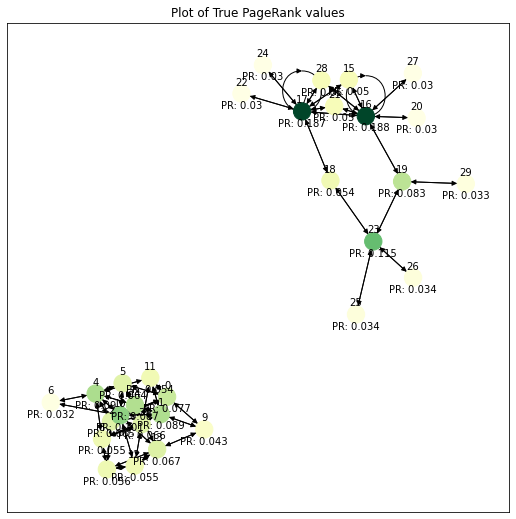

Plot with predicted labels
--------------------------


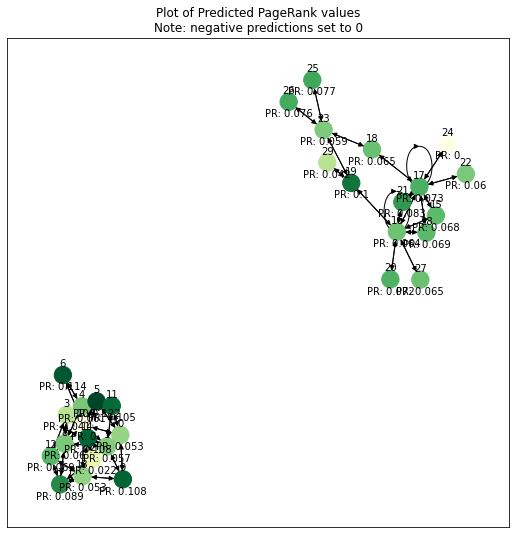

In [65]:
SAGE_model_h10_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 1.912829;		val loss 0.596344
Epoch 50,	loss: 1.879394;		val loss 0.586807
Epoch 100,	loss: 1.841001;		val loss 0.575878
Epoch 150,	loss: 1.798895;		val loss 0.563894
Epoch 200,	loss: 1.753794;		val loss 0.551054
Epoch 250,	loss: 1.706281;		val loss 0.537521
Epoch 300,	loss: 1.656846;		val loss 0.523433
Epoch 350,	loss: 1.605913;		val loss 0.508907
Epoch 400,	loss: 1.553636;		val loss 0.494008
Epoch 450,	loss: 1.500231;		val loss 0.478844
Test loss: 0.312262


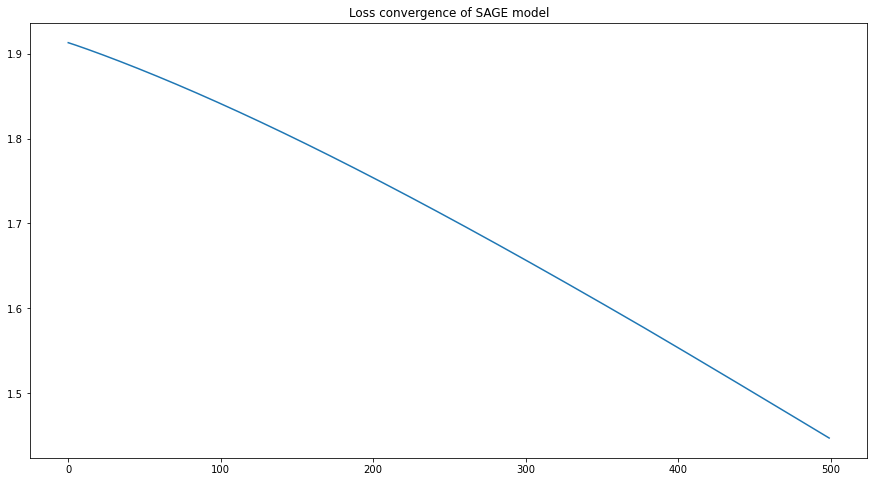



Plot with true labels
---------------------


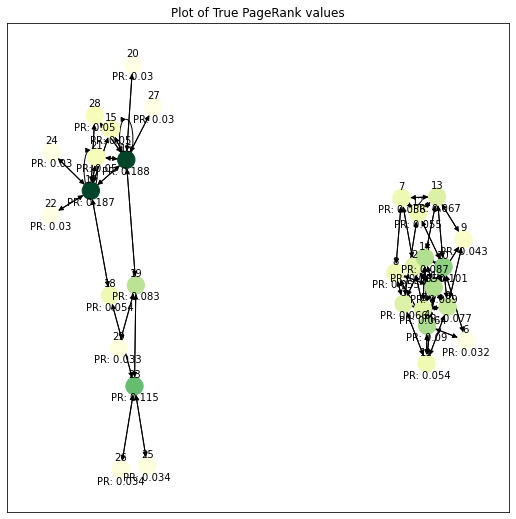

Plot with predicted labels
--------------------------


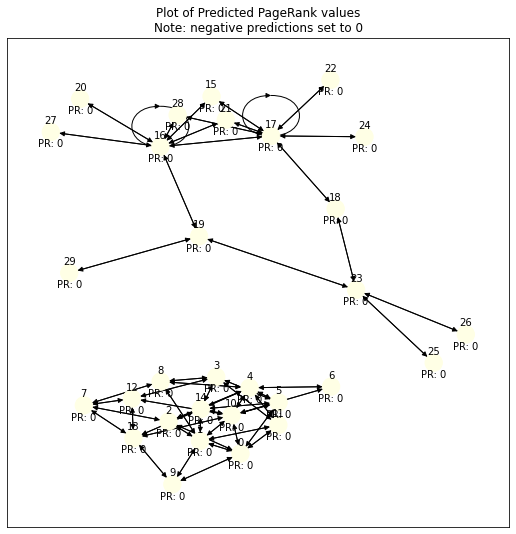

In [66]:
SAGE_model_h10_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.018996;		val loss 0.010379
Epoch 50,	loss: 0.013334;		val loss 0.007468
Epoch 100,	loss: 0.010623;		val loss 0.005788
Epoch 150,	loss: 0.00912;		val loss 0.004749
Epoch 200,	loss: 0.008055;		val loss 0.00402
Epoch 250,	loss: 0.007181;		val loss 0.003508
Epoch 300,	loss: 0.006491;		val loss 0.003174
Epoch 350,	loss: 0.005936;		val loss 0.002892
Epoch 400,	loss: 0.005549;		val loss 0.00266
Epoch 450,	loss: 0.005217;		val loss 0.002461
Test loss: 0.000676


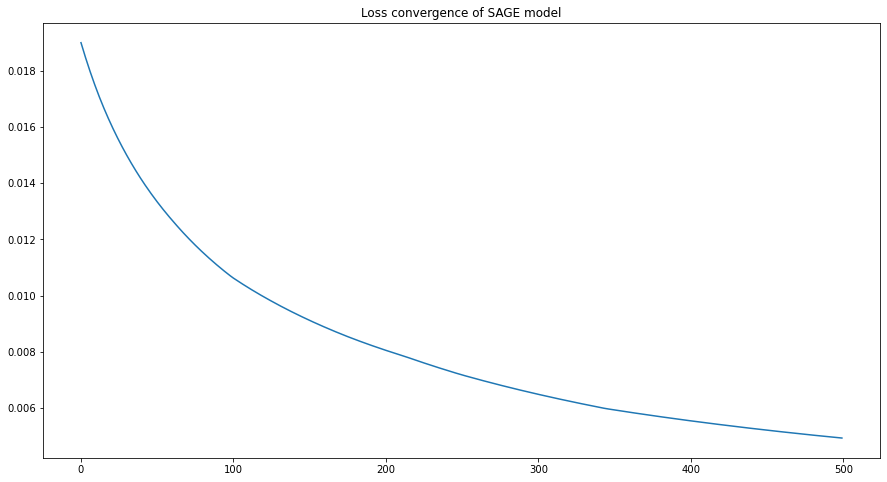



Plot with true labels
---------------------


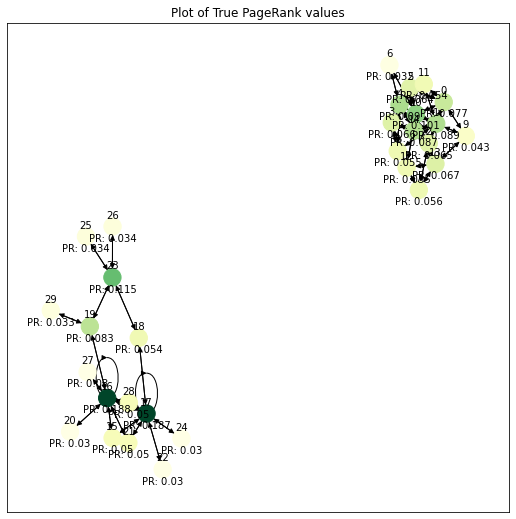

Plot with predicted labels
--------------------------


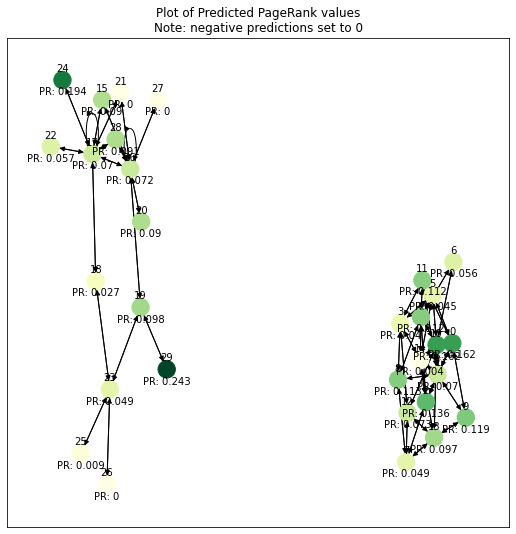

In [67]:
SAGE_model_h10_SGD_eye.run(print_graph_results=True)

## 4. Discussing the Results